# Computer Vision

## <font color='blue'>Tensor 101 (Tensor basics)</font>

---

This introduction only provides the very basics of working with tensors (in **PyTorch**). For a more comprehensive overview (and introduction), see the PyTorch [documentation](https://pytorch.org/docs/stable/index.html) and the [tutorials](https://pytorch.org/tutorials/).

---

## Content

- [Tensor types](#Tensor-types)
- [Writing device agnostic code](#Writing-device-agnostic-code)
- [Tensor creation and filling](#Tensor-creation-and-filling)
- [In-place operations](#In-place-operations)
- [Reduction operations](#Reduction-operations)
- [Indexing](#Indexing)
- [Slicing](#Slicing)
- [Views](#Views)
- [Expansion](#Expansion)
- [Images as tensors](#Images-as-tensors)
- [Operations](#Operations)
    - [Matrix-vector products](#Matrix-vector-products)
    - [Matrix-matrix products](#Matrix-matrix-products)
- [Interface to standard linear operations](#Interface-to-standard-linear-operations)    
    - [Solving linear least-squares regression](#Solving-linear-least-squares-regression)

---

Basically, a tensor is a *generalized matrix*. A ...

- ... 0d tensor is a scalar
- ... 1d tensor is a vector
- ... 2d tensor is a matrix
- ... 3d tensor can be interpreted as a vector of identically-sized matrices
- ... 4d tensor can be interpreted as a matrix of identically-sized matrices
- etc.

**Examples**

In [1]:
import torch
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
t0 = torch.rand(1)        # scalar
t1 = torch.rand(1,10)     # 1x10 vector
t2 = torch.rand(5,10)     # 5x10 matrix 
t3 = torch.rand(3,5,10)   # vector of length 3 of 3x5 matrices
t4 = torch.rand(4,3,5,10) # 4x3 matrix of 5x10 matrices

We will use tensors to <font color='blue'>encode</font> the input/output signals, intermediate outputs, and also the parameters (internal states) of our models. 

In **PyTorch**, we have efficient tensor operations available on CPU/GPU, automatic differentiation (will be discussed later), etc. If a tensor is stored in memory on a certain device (GPU/CPU), operations are performed by that device.

## Tensor types

We have the following data types available for tensors:

- `torch.float16`
- `torch.float32`
- `torch.float64`
- `torch.uint8`
- `torch.int8`
- `torch.int16`
- `torch.int32`
- `torch.int64`

For `torch.float32`, the corresponding CPU tensor is `torch.FloatTensor` and the corresponding GPU tensor is `torch.cuda.FloatTensor`.

For a full listing see [here](https://pytorch.org/docs/stable/tensors.html). 

Note that `torch.Tensor` defaults to `torch.FloatTensor`. The preferred construction of tensors happens via `torch.tensor`.

---

In [2]:
# Sanity check
x = torch.Tensor()
x.dtype

torch.float32

## Writing device agnostic code

In some cases, we might want to run our code on CPU, in other cases we might want to run it on the GPU. Writing device-agnostic code is simple in PyTorch. We just set the `device` variable to the correct device that we have available. 

Note that if you have multiple GPUs, we can directly specify the GPU ID via `cuda:x`, e.g., `cuda:2`.




In [3]:
use_gpu = True
if torch.cuda.is_available() and use_gpu: 
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('Using:', device)

Using: cpu


---

## Tensor creation and filling

In [4]:
# create an empty 8x8 tensor (i.e., a 8x8 matrix)
x = torch.empty(8, 8, 
                dtype=torch.float64, 
                device=device)

print(x)
print('Tensor type:', x.dtype)
print('Device:', x.device)

tensor([[  0.0000e+00,  6.9529e-310,  6.9529e-310,  6.9529e-310,  6.9529e-310,
          1.2648e-319,   0.0000e+00,   0.0000e+00],
        [ 1.2775e-319,   0.0000e+00,   4.7149e-62,   0.0000e+00,   1.3683e-71,
           0.0000e+00,   0.0000e+00,   0.0000e+00],
        [-2.5931e-306,  1.5341e-308,  1.3961e-309,   0.0000e+00,  8.3298e+151,
          6.3222e-310,   0.0000e+00,  6.9529e-310],
        [ 6.9529e-310,  6.9529e-310,  6.9529e-310,   0.0000e+00,  2.9644e-323,
          8.4880e-314,   0.0000e+00,   0.0000e+00],
        [ 2.3473e+251,   0.0000e+00,  7.7152e+199,   0.0000e+00,   0.0000e+00,
           0.0000e+00,  -0.0000e+00,   2.0039e+00],
        [ 1.3961e-309,  4.2440e-314,  9.6533e-315,   0.0000e+00,   0.0000e+00,
          6.9529e-310,  6.9529e-310,  6.9529e-310],
        [ 6.9529e-310,   0.0000e+00,  4.2440e-314,   0.0000e+00,   0.0000e+00,
          1.2648e-321,  4.9407e-324,   0.0000e+00],
        [  0.0000e+00,   0.0000e+00,   0.0000e+00,   0.0000e+00,   0.0000e+00,
    

We see that we have *uninitialized data*.

In [8]:
# 3x2 tensor filled with zeros
x = torch.zeros(3, 2, 
                device=device) 
print(x)
print('Tensor type', x.dtype)
print('Device:', x.device)

# tensor of same size as x, filled with zeros
y = torch.zeros_like(x).to(device) 
print('Tensor type:', y.dtype)
print('Device:', y.device)
print(x.size())
print(y.size())

tensor([[0., 0.],
        [0., 0.],
        [0., 0.]])
Tensor type torch.float32
Device: cpu
Tensor type: torch.float32
Device: cpu
torch.Size([3, 2])
torch.Size([3, 2])


In [13]:
# create 3x2x10 tensor (i.e., 3 matrices of size 2x10) of all ones
x = torch.ones(3, 2, 10, 
               device=device)
print(x)
print(x.size())
print('Tensor type:', x.dtype)
print('Device:', x.device)

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]],

        [[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]],

        [[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]])
torch.Size([3, 2, 10])
Tensor type: torch.float32
Device: cpu


We can also create tensors from numpy arrays. Unless we specify the tensor type directly, the `numpy` array type is inherited.

In [16]:
x = np.array(
    [
        [1.,2.,3.],
        [4.,5.,6.]
    ], dtype=np.float32)

# create tensor from numpy array
t = torch.tensor(x).to(device)
print(t)
print(t.dtype)

x = np.array(
    [
        [1,2,3],
        [4,5,6]
    ])
t = torch.tensor(x, 
                 dtype=torch.float32,
                 device=device)
print(t)
print(t.dtype)
print(t.size())

tensor([[1., 2., 3.],
        [4., 5., 6.]])
torch.float32
tensor([[1., 2., 3.],
        [4., 5., 6.]])
torch.float32
torch.Size([2, 3])


---

## In-place operations

Operations that operate directly on the tensor and *do not* make a copy.

In [18]:
x = torch.empty(3, 1, device=device, dtype=torch.float32)
y = torch.empty(3, 1, device=device, dtype=torch.float32)
z = torch.empty(3, 1, device=device, dtype=torch.float32)

x.fill_(3)  # filled with ALL ones
y.zero_()   # filled with ALL zeros
z.normal_() # filled with elements drawn from N(0,1) - i.e., a standard Gaussian

print(x)
print(y)
print(z)

tensor([[3.],
        [3.],
        [3.]])
tensor([[0.],
        [0.],
        [0.]])
tensor([[ 2.8312],
        [-2.1057],
        [ 0.9179]])


**Note**: In-place operations are post-fixed with a `_`, such as `x.zero_()` or `x.fill_(1.0)` or `x.normal_()`. The latter fills the tensor with values sampled from a standard Gaussian $\mathcal{N}(0,1)$.

---

## Reduction operations

In [21]:
x = torch.zeros(3, 2).normal_()
print(x)

s0 = x.sum()  # sum over all tensor values
s1 = x.mean() # mean over all tensor values
s2 = x.std()  # computed the standard deviation over all tensor values
s3 = x.norm() # matrix norm of x (in that case Frobenius norm)

print(s0.item())
print(s1.item())
print(s2.item())
print(s3.item())

tensor([[-0.5179, -0.0289],
        [-1.0486, -0.6605],
        [-0.8855, -1.4608]])
-4.602268695831299
-0.7670447826385498
0.48845747113227844
2.173269271850586


Note that While `s0` ... `s3` are scalars, they are encoded as a 0d tensor. To get a Python number, we call `.item()`.

We can also perform these operations over specific dimensions.

In [28]:
x = torch.rand(10,1,10)

# x contains 10 1x10 vectors - lets sum over the elements of each vector
sum_v0 = x.sum(dim=2)
# check first element
sum_v1 = x[0,...].sum()

assert sum_v0[0] == sum_v1

---

## Indexing

Indexing starts at 0 (as usual in our context). Say you have a $3 \times 2$ tensor `x`. The dimensionality along the first dimension is $3$ and along the second dimension $2$. To get the value at $(i,j)$, we specify
`x[i,j]`.

In [31]:
x = torch.rand(3, 2, 2, 
               device=device)
print(x)
print(x[0,1,1].item())

tensor([[[0.0870, 0.7178],
         [0.3881, 0.9149]],

        [[0.7618, 0.0802],
         [0.1825, 0.2170]],

        [[0.2977, 0.8359],
         [0.6618, 0.6854]]])
0.9148679375648499


In [32]:
x = torch.empty(3, 10, 12, 
               device=device).normal_()
print(x[0,8,2])

tensor(-1.6008)


---
## Slicing

We can also extract certain parts of a tensor, using *slicing*, e.g., if `x = torch.rand(3,10,12)` as before, we have $3$ $10 \times 12$ matrices in this tensor, or, a vector (of length 3) of $10 \times 12$ matrices. To extract the first vector element (i.e., the first $10 \times 12$ matrix), we write

In [38]:
x = torch.rand(3,2,2)
print(x.size())
z = x[0,:,:]    # equivalent to x[0,...]
print(z.size())

torch.Size([3, 2, 2])
torch.Size([2, 2])


**Note**: If we modify a value in `z`, we also modify the value in `x`.

In [42]:
print('Without cloning ...')
x = torch.rand(1,2)
print('x (original):', x)
z = x
z[0,0] = 1.
print('x (original, after modification of z):', x)
print('z:', x)
print()

x = torch.rand(1,2)
print('With cloning ...') 
print('x (original):', x)
z = x.clone()
z[0,0] = 1.
print('x (original, after modification of z):', x)
print('z:', z)

Without cloning ...
x (original): tensor([[0.5889, 0.6602]])
x (original, after modification of z): tensor([[1.0000, 0.6602]])
z: tensor([[1.0000, 0.6602]])

With cloning ...
x (original): tensor([[0.9160, 0.4613]])
x (original, after modification of z): tensor([[0.9160, 0.4613]])
z: tensor([[1.0000, 0.4613]])


Slicing also allows to set all values of a slice simultaneously:

In [45]:
x = torch.empty(3, 1, 2, 
               device=device).normal_()

print(x)
x[0,:,:] = 2
print(x)
print()

x[0,:,:].zero_()
print(x)

tensor([[[-0.8764,  0.3463]],

        [[-0.5787, -0.5336]],

        [[ 1.9202, -0.0117]]])
tensor([[[ 2.0000,  2.0000]],

        [[-0.5787, -0.5336]],

        [[ 1.9202, -0.0117]]])

tensor([[[ 0.0000,  0.0000]],

        [[-0.5787, -0.5336]],

        [[ 1.9202, -0.0117]]])


---

## Views

We can also easily create different *views* of a tensor. A common procedure is to view the tensor as a vector, which can easily be done via: 

In [62]:
x = torch.tensor([[1.,2.,3.],[4.,5.,6.]])
print(x)
print(x.size())
print(x.dtype)
print()

# 1d view
v0 = x.view(-1)
print(v0)
print()

# sanity check
#print(x.storage().data_ptr() == v0.storage().data_ptr())

# view as 3x2 tensor
v1 = x.view(3,-1)
print(v1)
print()

# ... or more explicitely
v2 = x.view(3, 2)
print(v2)
print()

tensor([[1., 2., 3.],
        [4., 5., 6.]])
torch.Size([2, 3])
torch.float32

tensor([1., 2., 3., 4., 5., 6.])

tensor([[1., 2.],
        [3., 4.],
        [5., 6.]])

tensor([[1., 2.],
        [3., 4.],
        [5., 6.]])



`v0` now is a 1d view of the tensor `x`. Again, modifying `v0` modifies `x`. Also, the original size of `x` does not change.

---

## Expansion

*Expansion* expands singleton dimensions to a larger size (by creating a new view *without* memory consumption). In the next example we have a $2 \times 3$ tensor and want to expand this one to a $3 \times 2 \times 3$ tensor, i.e., expansion along the first singleton dimension.

In [63]:
x = torch.tensor(
    [
        [1,2,3],
        [4,5,6]
    ])

print(x.size())
print()

y = x.expand(5,2,3)
print(y)
print(y.size())

torch.Size([2, 3])

tensor([[[1, 2, 3],
         [4, 5, 6]],

        [[1, 2, 3],
         [4, 5, 6]],

        [[1, 2, 3],
         [4, 5, 6]],

        [[1, 2, 3],
         [4, 5, 6]],

        [[1, 2, 3],
         [4, 5, 6]]])
torch.Size([5, 2, 3])


Using `unsqueeze` we can also expand tensors by adding ONE singleton dimension. Below is an example of unsqueezing along dimension 0. The opposite operation is `squeeze`, obviously :)

In [64]:
x = torch.tensor(
    [
        [1,2,3],
        [4,5,6]
    ])
x = x.unsqueeze(0)
print(x.size())
x = x.squeeze()
print(x.size())

torch.Size([1, 2, 3])
torch.Size([2, 3])


---

## Images as tensors

Images are just tensors ... it's that simple!

In [66]:
import torch
import torchvision

# download a popular computer vision dataset
cifar = torchvision.datasets.CIFAR10(
    '../data/cifar10/', 
    train = False,
    download = True)

Files already downloaded and verified


`cifar` is an instance of `torchvision.dataset`. We can access it's elements via `cifar[idx]` and get a tuple of `(data, label)`. `data` is a `PIL` image, `label` should be an integer. 

In [78]:
img = cifar[600][0]
lab = cifar[600][1]
print(type(img))
print(type(lab))

<class 'PIL.Image.Image'>
<class 'int'>


Internally, `cifar` has a `data` class variable which holds all images in a numpy array. Lets convert this into a tensor:

In [81]:
print(cifar.data.shape)

# we use permute to switch dimensions, as originally images are in the format channels x W x H
x = torch.from_numpy(cifar.data).permute(0, 3, 1, 2).float()
print(x.type())
print(x.size())

(10000, 32, 32, 3)
torch.FloatTensor
torch.Size([10000, 3, 32, 32])


So, using the `torchvision` module, we have just loaded *all* images from the CIFAR-10 testing set. CIFAR-10 are RGB images (hence 3 color channels) and we have 10,000 images available. Consequently, we get a $10000 \times 3 \times 32 \times 32$ tensor.

This is the convention for multi-channel images in PyTorch, i.e., nr. of images times channels times width times height. For visualization using `matplotlib` we need to permute the channels, though:

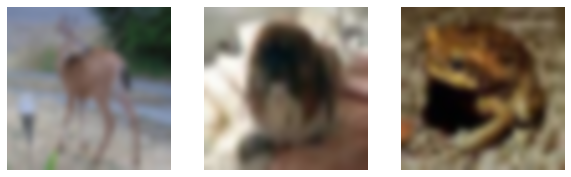

In [83]:
def show(img):
    npimg = img.numpy()
    plt.imshow(
        np.transpose(npimg, (1, 2, 0)), 
        interpolation='bicubic')
    plt.axis('off')

plt.figure(figsize=(10,3))
plt.subplot(131)
show(x[100,:,:,:]/255.)
plt.subplot(132)
show(x[200,:,:,:]/255.)
plt.subplot(133)
show(x[300,:,:,:]/255.)

PyTorch also has its own convenience methods to quickly visualize images in a tensor on a grid (using `torchvision.utils.make_grid`. E.g., we can narrow the tensor containing all CIFAR10 testing images along its first dimension to only contain 48 images.

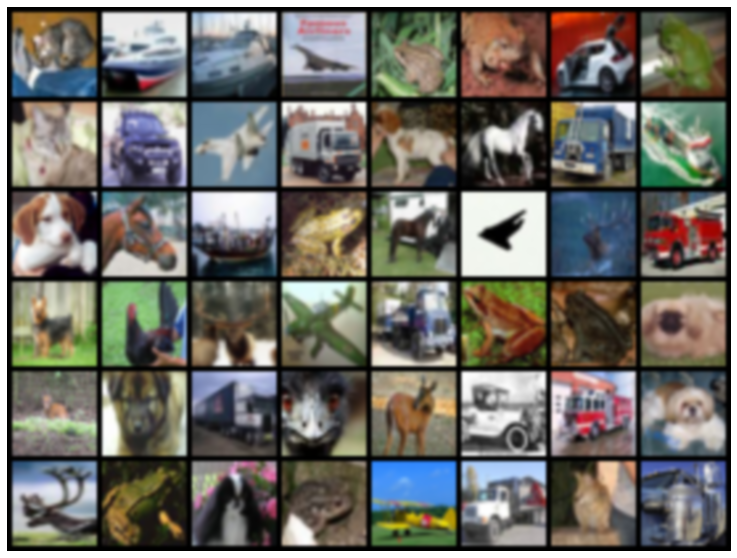

In [84]:
from torchvision.utils import make_grid

y = x.narrow(0, 0, 48).float()
collage = make_grid(y, normalize=True)
plt.figure(figsize=(20,10))
show(collage)

---

## Operations

### Point-wise operations

In [85]:
# Multiplication
x = torch.ones(3,1)*2
y = torch.ones(3,1)*4
print(x)
print(y)

z = x*y
print(z)

tensor([[2.],
        [2.],
        [2.]])
tensor([[4.],
        [4.],
        [4.]])
tensor([[8.],
        [8.],
        [8.]])


In [86]:
# Squaring
x = torch.ones(3,1)*2.
print(x**2)
print(torch.pow(x,2.)) # equivalent

tensor([[4.],
        [4.],
        [4.]])
tensor([[4.],
        [4.],
        [4.]])


### Matrix-vector products

In [89]:
M = torch.tensor(
    [
        [1,2,3],
        [4,5,6],
        [7,8,0]
    ]).to(device)
y = torch.tensor([1,2,3]).to(device)
M.mv(y)

tensor([14, 32, 23])

### Matrix-matrix products

Matrix-matrix products are written via `@`. For a 2d tensor `M`, we can also equivalently write `M.mm(M)` to compute the matrix multiplication of `M` with itself, or `torch.mm(M,M)`.

In [90]:
print(M @ M)         # Variant 1
print(M.mm(M))       # equivalent to Variant 1 
print(torch.mm(M,M)) # equivalent to Variant 1

tensor([[30, 36, 15],
        [66, 81, 42],
        [39, 54, 69]])
tensor([[30, 36, 15],
        [66, 81, 42],
        [39, 54, 69]])
tensor([[30, 36, 15],
        [66, 81, 42],
        [39, 54, 69]])


---
## Interface to standard linear operations

For instance, we can use `torch.lstsq` as a **least-squares** problem solver. Say you want to solve

$$ 
 \min_{\mathbf{X}}  \|\mathbf{A}\mathbf{X}-\mathbf{B}\|_2.
$$

for a given full-rank matrix $\mathbf{A}$ ($m \times n$) and a matrix $\mathbf{B}$ ($m \times k$). 

In the following **example**, $\mathbf{B}$ is of size $3 \times 1$ and $\mathbf{A}$ is of size $3 \times 3$. Both matrices will be filled with values from a standard Normal distribution.

In [92]:
B = torch.empty(3,1).normal_()   # 2d tensor of size 3x1 (i.e., a vector)
A = torch.empty(3,3).normal_()   # 2d tensor (matrix)

print(A)
print(B)

# solve min_X ||AX - B||_2
x, _ = torch.lstsq(B,A) 

# some arbitrary vector just as a sanity check
z = torch.rand(3,1)

# Note: both x and z are 3x1 matrices (2d) tensors representing vectors
# Hence, we use mm() to compute matrix-matrix products.

Ax = A.mm(x)  
Az = A.mm(z) 

print('Norm (using x): {:.5f}'.format(torch.norm(Ax.view(3,) - B.view(3,)).item()))
print('Norm (using z): {:.5f}'.format(torch.norm(Az.view(3,) - B.view(3,)).item()))

tensor([[-0.2963, -0.8945,  2.6124],
        [-0.4724, -1.6949,  0.6781],
        [ 1.9629, -0.1250,  1.1137]])
tensor([[-0.2451],
        [-0.5924],
        [ 1.7829]])
Norm (using x): 0.00000
Norm (using z): 1.40375


### Solving linear least-squares regression

We are given 

$$(x_1,y_1), \ldots, (x_N,y_N)$$

with $(x_i,y_i) \in \mathcal{Z} = \mathbb{R} \times \mathbb{R}$ and want to fit the best-fitting **line** through this data (in a least-squares sense), i.e., a model of the form

$$ f(x;a,b) = ax + b$$

This linear least squares **optimization problem** (in the parameters $a,b$) can be written as

$$ \arg\min_{a,b} \frac{1}{N} \sum_{i=1}^N (ax_i +b -y_i)^2$$

i.e., we try to minimize the sum of squared residuals $(ax_i +b -y_i)$.

Upon obtaining a solution, we can put in a (previously unseen) $x^*$ and predict the corresponding value $y^*$ via 

$$f(x^*; a,b)=\hat{y}$$

The toy data we use is taken from the [Isotonic Regression](https://scikit-learn.org/stable/auto_examples/plot_isotonic_regression.html#sphx-glr-auto-examples-plot-isotonic-regression-py) example from `sklearn` (to find a non-decreasing approximation function).

In [93]:
from sklearn.utils import check_random_state

N = 100
x = np.arange(N)
rs = check_random_state(0)
y = rs.randint(-50, 50, size=(N,)) + 50. * np.log1p(np.arange(N))

Note that `np.log1p(x)` returns $\log(1+x)$ and the toy data can obviously not modeled by a linear function - However, for our purposes this is *linear enough* as we will see.

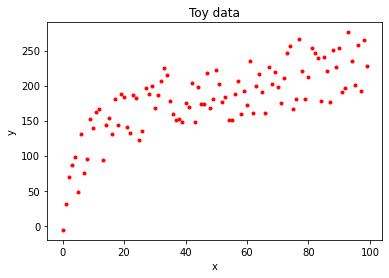

In [94]:
plt.plot(x,y,'r.')
plt.xlabel('x');
plt.ylabel('y');
plt.title('Toy data');

**Setting up the problem**    

First, we construct our $N \times 2$ data matrix $\mathbf{A}$ as follows:

$$\mathbf{A} = \left(
\begin{matrix}
x_1 & 1 \\
\vdots & \vdots \\
x_N & 1
\end{matrix}
\right)$$

Note the additional column of all 1's - this is to include the offset (b).
We put our targets $y_i$ in a $N \times 1$ matrix (i.e., a colum vector)

$$\mathbf{B} = \left(
\begin{matrix}
y_1 \\
\vdots \\
y_N
\end{matrix}
\right)$$

**Goal**:

$$
\left(
\begin{matrix}
x_1 & 1 \\
\vdots & \vdots \\
x_N & 1
\end{matrix}
\right) 
\left(\begin{matrix}
a \\
b
\end{matrix}
\right)
\approx
\left(
\begin{matrix}
y_1 \\
\vdots \\
y_N
\end{matrix}
\right)
$$

Hence, encoding $\mathbf{X} = [a,b]^\top$, we want to solve

$$ \min_{\mathbf{X}} \frac{1}{N} \| \mathbf{A}\mathbf{X} - \mathbf{B} \|_2^2$$

Note that this minimization problem is equivalent to 

$$ \min_{\mathbf{X}} \| \mathbf{A}\mathbf{X} - \mathbf{B} \|_2$$

as square-rooting the norm is a monotonic transformation (i.e., it does not matter which one we minimize). The latter, however, fits our setting of the `torch.lstsq()` function. Similarly, the missing $1/N$ term does not change the optimization result.

In [97]:
data_x = torch.empty(N, 2, dtype=torch.float)
data_y = torch.empty(N, 1, dtype=torch.float)

data_x[:,0] = torch.tensor([x])
data_x[:,1] = 1.
data_y[:,0] = torch.tensor([y])

data_x = data_x.to(device)
data_y = data_y.to(device)

In this example `data_x` acts as our matrix $\mathbf{A}$, and `data_y` acts as our matrix $\mathbf{B}$. $\mathbf{A}$ is of size $(m,n) = (N,2)$, $\mathbf{B}$ of size $(n,k) = (N,1)$. According to the documentation the returned solution has size $(\max(m,n), k)$, so we will get a matrix of size $(100,1)$ back.

In [98]:
alpha, _ = torch.lstsq(data_y, data_x)
print(alpha.size())

torch.Size([100, 1])


Again, according to the documentation, the first $n$ (in our case $n=2$) rows contain the solution, the remaining $100-2$ entries contain the residual sum of squares for the solution.

In [103]:
a = alpha[0,0].item()
b = alpha[1,0].item()
print(a,b)

1.3134796619415283 115.08245086669922


Just a quick comparison to the actual isotonic regression example in `sklearn`:

In [100]:
from sklearn.isotonic import IsotonicRegression
ir = IsotonicRegression()
y_ = ir.fit_transform(x, y)

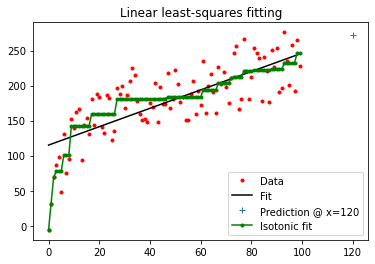

In [101]:
plt.figure()
plt.plot(x, y, 'r.', label='Data')
plt.plot(x, a*x + b, 'black', label='Fit')
plt.plot(120, a*120+b, '+', label='Prediction @ x=120')
plt.plot(x, y_, 'g.-', label='Isotonic fit')
plt.legend();
plt.title('Linear least-squares fitting');

In [104]:
from sklearn.metrics import r2_score

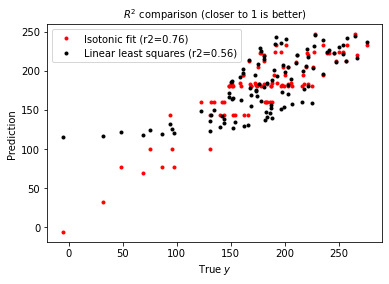

In [105]:
plt.plot(y,y_,'.',color='red', label='Isotonic fit (r2={:.2f})'.format(r2_score(y, y_)))
plt.plot(y,a*x+b,'.',color='black', label='Linear least squares (r2={:.2f})'.format(r2_score(y, a*x+b)))
plt.xlabel('True $y$');
plt.ylabel('Prediction');
plt.legend();
plt.title(r'$R^2$ comparison (closer to 1 is better)', fontsize=10);